## Predictors of Ride Share Tipping 
### Initial EDA 

* Alice Wright - aew7j
* Edward Thompson - ejt8b
* Michael Davies -  mld9s
* Sam Parsons - sp8hp

This aim of this project is to explore predictors of tipping behavior by customers of “transportation network providers” i.e. rideshares such as Uber, Lyft, etc.  We leverage data from the [Transport Network Provider data set](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p), maintain by the City of Chicago, as it is large (169M records and 21 columns), relatively clean, anonymized, and accessible via API.

For example: 
* Is there a relationship between tips and the total fare?
* Are there temporal patterns of tipping? (workday stat, bar close, weekday, weekend, etc)
* Is there a geographic pattern? (downtown pickup, north shore, airport, etc)
* Is there a relationship between length of ride and tipping? (do longer rides result in tips)
* Is the likelihood of tipping changing over time?  

What follows in initial exploratory data analysis, including:

* Number of records 
    * full data set: 49108003, downsampled data set: 24414
* Number of columns 
    * full data set: 21, this changes during data cleaning and feature engineering
* Statistical summary of response variable. 
    * See below for summary statistics of response as a continuous var and after binarizing it.
    * Note here that, after ploting the response as a binary var, we see both a potential class imbalance issue as well as a possible outler observation.
* Statistical summary of potential predictor variables (if there are a large number of predictors, select the top 10)
    * See below for summary statistics of top 10 vars
* Summary plots
    * A number of exploratory plots are below

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, BooleanType
import pyspark.sql.types as typ
import pyspark.sql.functions as F
import os
from pyspark.sql.types import *

# context manager
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("mllib_classifier") \
        .config("spark.executor.memory", '21g') \
        .config('spark.executor.cores', '2') \
        .config('spark.executor.instances', '3') \
        .config("spark.driver.memory",'1g') \
        .getOrCreate()
sc = spark.sparkContext

### Read in our Dataset

**Create a Custom Schema.  ** 

This schema was been primarly determined by using a much smaller dataset and letting spark infer the schema.  We encountered an issue with spark reading in the ENTIRE dataset as NULL when there was a type mismatch.  Only the data we are likely to use later has been assigned to a specific type, otherwise it is left as a string type.

In [2]:
# create a custom schema.  

customSchema = StructType([
    StructField('Trip_ID', StringType(), True),        
    StructField('Trip_Start_Timestamp', StringType(), True),
    StructField('Trip_End_Timestamp', StringType(), True),
    StructField('Trip_Seconds', DoubleType(), True),
    StructField('Trip_Miles', DoubleType(), True),
    StructField('Pickup_Census_Tract', StringType(), True),
    StructField('Dropoff_Census_Tract', StringType(), True),
    StructField('Pickup_Community_Area', DoubleType(), True),
    StructField('Dropoff_Community_Area', DoubleType(), True),
    StructField("Fare", DoubleType(), True),
    StructField("Tip", DoubleType(), True),
    StructField("Additional_Charges", DoubleType(), True),
    StructField("Trip_Total", StringType(), True),
    StructField("Shared_Trip_Authorized", BooleanType(), True),
    StructField("Trips_Pooled", DoubleType(), True),
    StructField('Pickup_Centroid_Latitude', StringType(), True),
    StructField('Pickup_Centroid_Longitude', StringType(), True),
    StructField('Pickup_Centroid_Location', StringType(), True),
    StructField('Dropoff_Centroid_Latitude', StringType(), True),
    StructField('Dropoff_Centroid_Longitude', StringType(), True),
    StructField('Dropoff_Centroid_Location', StringType(), True)
])
#read in the data to a dataframe
df = spark.read.csv('/../../project/ds5559/Alice_Ed_Michael_Sam_project/BigTrips.csv', header = True, schema=customSchema)

### Initial data cleaning and exploratory data analysis (EDA)

Note - The data set is extremely large. So, for the purpose of EDA, we down sampled down the data.

Additionally, to make the initial data exploration more manageable, we focused on those variables that appeared to address our research questions. Additionally, we dropped variables such as, "end time" because it was anonymized to within 15 minutes. Additionally, the variable is redundant and can be derived from other variables. 

**Below shows the resulting dataframe, the dataframe shape, summary statistics, and initial exploratory plots**

In [3]:
#Keeping variables of interest
df = df.drop('Trip_ID',
             'Trip_End_Timestamp', 
             'Pickup_Census_Tract',
             'Dropoff_Census_Tract',
             'Pickup_Centroid_Latitude',
             'Pickup_Centroid_Longitude', 
             'Pickup_Centroid_Location', 
             'Dropoff_Centroid_Latitude', 
             'Dropoff_Centroid_Longitude', 
             'Dropoff_Centroid_Location',
             'Shared_Trip_Authorized')
df.printSchema()

root
 |-- Trip_Start_Timestamp: string (nullable = true)
 |-- Trip_Seconds: double (nullable = true)
 |-- Trip_Miles: double (nullable = true)
 |-- Pickup_Community_Area: double (nullable = true)
 |-- Dropoff_Community_Area: double (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tip: double (nullable = true)
 |-- Additional_Charges: double (nullable = true)
 |-- Trip_Total: string (nullable = true)
 |-- Trips_Pooled: double (nullable = true)



**Initial Exploratory Data Analysis**

Below shows the resulting dataframe, the dataframe shape, summary statistics, and initial exploratory plots

In [4]:
print("The total observations in the this data set are {}".format(df.count()))

The total observations in the this data set are 49108003


In [5]:
df2 = df.sample(False, .0005, 1221)
print("The number of observations in the downsampled set is {}".format(df2.count()))

The number of observations in the downsampled set is 24414


In [6]:
print("Summary Statistics")
df2.describe().show()

Summary Statistics
+-------+--------------------+------------------+-----------------+---------------------+----------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|Trip_Start_Timestamp|      Trip_Seconds|       Trip_Miles|Pickup_Community_Area|Dropoff_Community_Area|              Fare|               Tip|Additional_Charges|        Trip_Total|       Trips_Pooled|
+-------+--------------------+------------------+-----------------+---------------------+----------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|               24414|             24414|            24414|                22641|                 22503|             24414|             24414|             24414|             24414|              24414|
|   mean|                null|1001.8898582780372|6.450643073646268|    27.23086436111479|    27.551037639425854|11.870033587285983|0.557753747849

### Response Variable

* See below for summary statistics of the response variable.
* We also convert the response variable to a binary variable for later classification models. 
* Below is a boxplot showing the distribution of tips on fares.

Note, here we see a class imbalance in the response variable and a possible outlier issue.

In [7]:
df2.select("Tip").describe().show()

+-------+------------------+
|summary|               Tip|
+-------+------------------+
|  count|             24414|
|   mean|0.5577537478495945|
| stddev|1.6511623431201607|
|    min|               0.0|
|    max|              50.0|
+-------+------------------+



**Transform Tip into a binary variable**

Here we transform the tip such that it 0 = no tip and 1 = a tip.

In [8]:
# https://spark.apache.org/docs/2.2.0/ml-features.html#binarizer
from pyspark.ml.feature import Binarizer
#binarizer = Binarizer(threshold=0.5, inputCol="feature", outputCol="binarized_feature")
binarizer = Binarizer(threshold=0, inputCol="Tip", outputCol="binarized_tip")
binarizedTip = binarizer.transform(df2)

binarizedTip.groupby('binarized_tip').count().sort('binarized_tip').show()
#binarizedTip2 = binarizedTip.withColumn("Tip_bool",binarizedTip.binarized_tip.cast(BooleanType())).printSchema()

+-------------+-----+
|binarized_tip|count|
+-------------+-----+
|          0.0|20376|
|          1.0| 4038|
+-------------+-----+



### Exploratory Plots

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

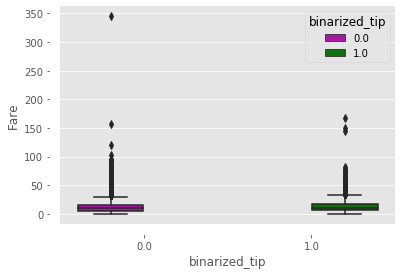

In [10]:
#https://seaborn.pydata.org/examples/grouped_boxplot.html
binarizedTip.cache()
sns.boxplot(x="binarized_tip", y="Fare",
            hue="binarized_tip", palette=["m", "g"],
            data=binarizedTip.toPandas())
sns.despine(offset=10, trim=True)
plt.show();

### Pairwise plot of features

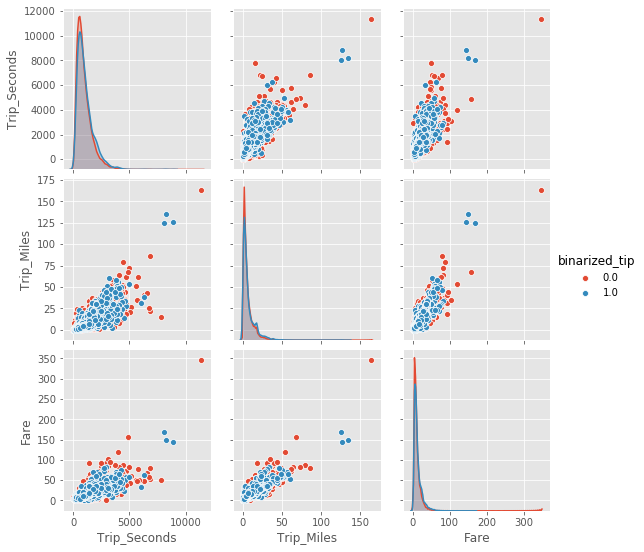

In [11]:
# https://docs.qubole.com/en/latest/user-guide/notebooks-and-dashboards/notebooks/jupyter-notebooks/data-visualization-jupy/plot-python-libraries.html
binarizedTip.cache()
#print(sns)
g = sns.pairplot(binarizedTip.toPandas(), vars=['Trip_Seconds', 'Trip_Miles', 'Fare'], hue = "binarized_tip");
plt.show();

### Fare and Tip Heatmap

In [12]:
#https://spark.apache.org/docs/2.2.0/api/python/pyspark.sql.html#module-pyspark.sql.functions
heatmap_data = df2.groupby('Fare','Tip').count().sort('Fare','Tip').groupby('Fare').pivot('Tip').sum("count").sort('Fare')
heatmap_data.cache()

DataFrame[Fare: double, 0.0: bigint, 1.0: bigint, 2.0: bigint, 3.0: bigint, 4.0: bigint, 5.0: bigint, 6.0: bigint, 7.0: bigint, 8.0: bigint, 9.0: bigint, 10.0: bigint, 11.0: bigint, 12.0: bigint, 13.0: bigint, 14.0: bigint, 15.0: bigint, 16.0: bigint, 18.0: bigint, 20.0: bigint, 21.0: bigint, 22.0: bigint, 25.0: bigint, 35.0: bigint, 36.0: bigint, 50.0: bigint]

In [13]:
hm_data = np.array(heatmap_data.drop('Fare').toPandas())

In [14]:
#https://numpy.org/doc/stable/reference/generated/numpy.flipud.html#numpy.flipud
hm_data = np.flipud(hm_data.transpose())

In [15]:
#https://mungingdata.com/pyspark/column-to-list-collect-tolocaliterator/
fares = list(heatmap_data.select('Fare').toPandas()['Fare'])
tips = sorted([float(x) for x in heatmap_data.columns if x != 'Fare'], reverse=True)

/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 1.0, 'Tip Amounts by Fare Amounts')

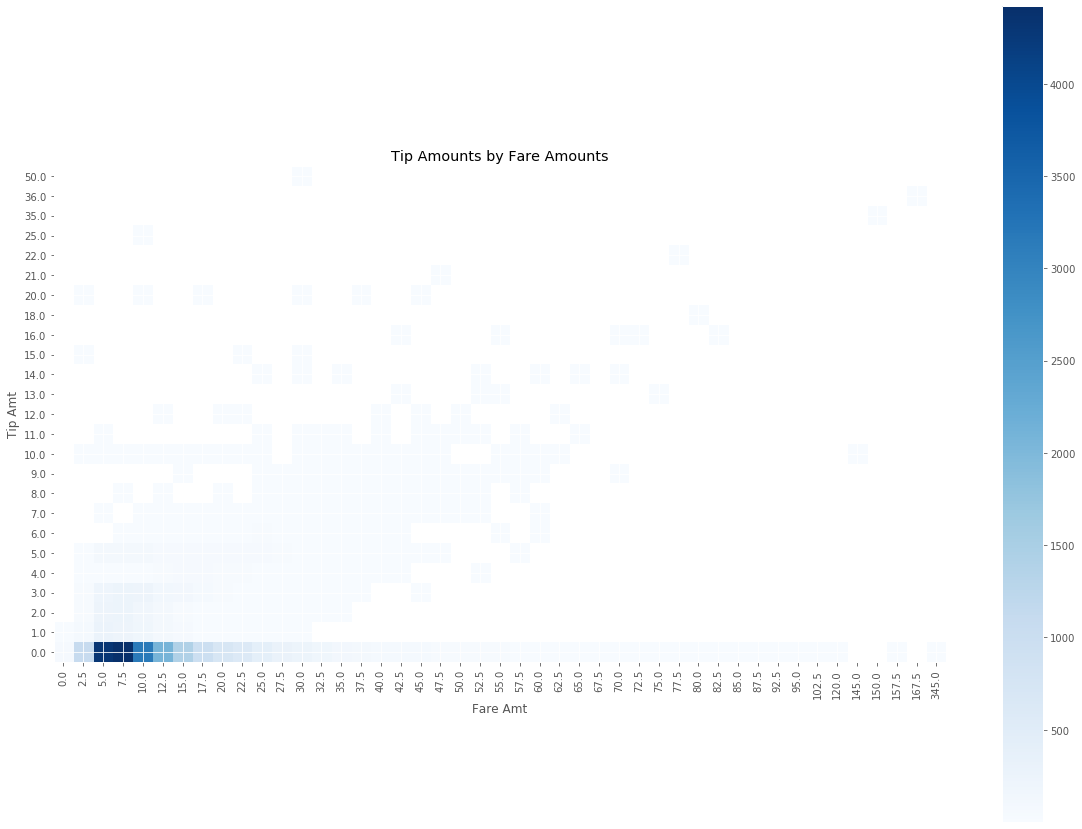

In [16]:
#https://www.pythonpool.com/matplotlib-figsize/
plt.figure(figsize=(20,15))
plt.axes().set_facecolor("#ffffff")
plt.axes().set_ylabel("Tip Amt")
plt.axes().set_xlabel("Fare Amt")
#https://www.pythonpool.com/matplotlib-heatmap/
plt.xticks(ticks=np.arange(len(fares)),labels=fares,rotation=90)
plt.yticks(ticks=np.arange(len(tips)),labels=tips)
hm = plt.imshow(hm_data,cmap='Blues',interpolation="none")
plt.colorbar(hm)
plt.title("Tip Amounts by Fare Amounts")

In [17]:
heatmap_data = df2.groupby('Pickup_Community_Area','Dropoff_Community_Area').count().\
                    sort('Pickup_Community_Area','Dropoff_Community_Area').groupby('Pickup_Community_Area').pivot('Dropoff_Community_Area').sum("count").sort('Pickup_Community_Area')
#heatmap_data = heatmap_data.groupby('Pickup_Community_Area').pivot('Dropoff_Community_Area').count()
heatmap_data.cache()

DataFrame[Pickup_Community_Area: double, null: bigint, 1.0: bigint, 2.0: bigint, 3.0: bigint, 4.0: bigint, 5.0: bigint, 6.0: bigint, 7.0: bigint, 8.0: bigint, 9.0: bigint, 10.0: bigint, 11.0: bigint, 12.0: bigint, 13.0: bigint, 14.0: bigint, 15.0: bigint, 16.0: bigint, 17.0: bigint, 18.0: bigint, 19.0: bigint, 20.0: bigint, 21.0: bigint, 22.0: bigint, 23.0: bigint, 24.0: bigint, 25.0: bigint, 26.0: bigint, 27.0: bigint, 28.0: bigint, 29.0: bigint, 30.0: bigint, 31.0: bigint, 32.0: bigint, 33.0: bigint, 34.0: bigint, 35.0: bigint, 36.0: bigint, 37.0: bigint, 38.0: bigint, 39.0: bigint, 40.0: bigint, 41.0: bigint, 42.0: bigint, 43.0: bigint, 44.0: bigint, 45.0: bigint, 46.0: bigint, 47.0: bigint, 48.0: bigint, 49.0: bigint, 50.0: bigint, 51.0: bigint, 52.0: bigint, 53.0: bigint, 54.0: bigint, 55.0: bigint, 56.0: bigint, 57.0: bigint, 58.0: bigint, 59.0: bigint, 60.0: bigint, 61.0: bigint, 62.0: bigint, 63.0: bigint, 64.0: bigint, 65.0: bigint, 66.0: bigint, 67.0: bigint, 68.0: bigint, 69

In [18]:
hm_data = np.array(heatmap_data.drop('Pickup_Community_Area').toPandas())

In [19]:
hm_data = np.flipud(hm_data.transpose())
#https://mungingdata.com/pyspark/column-to-list-collect-tolocaliterator/
pickups = sorted(list(heatmap_data.select('Pickup_Community_Area').toPandas()['Pickup_Community_Area']))
dropoffs = sorted([float("nan") if x == "null" else float(x) for x in heatmap_data.columns if x != 'Pickup_Community_Area'], reverse=True)

/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 1.0, 'Tip Heatmap by Pickup and Dropoff Community Areas')

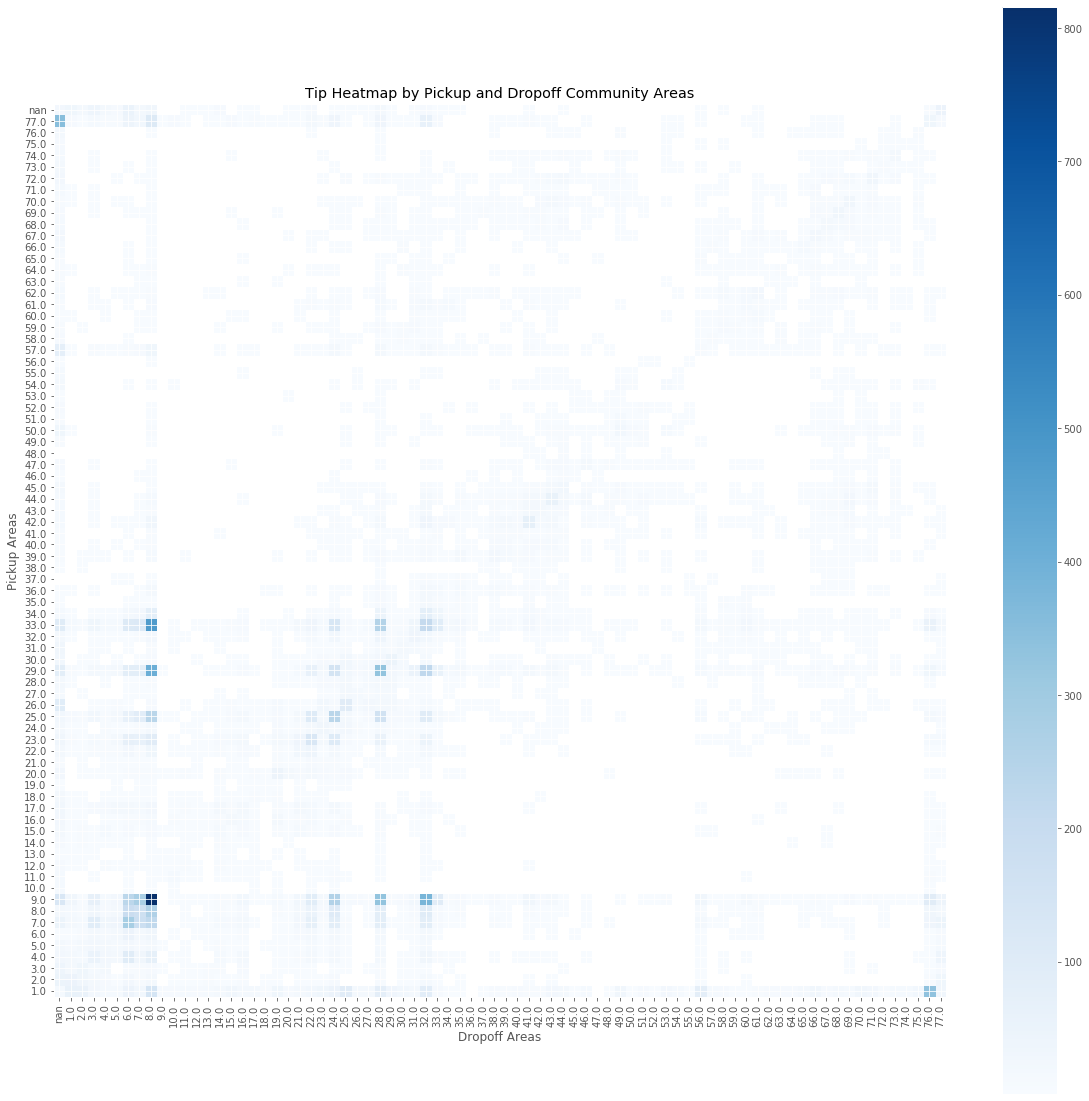

In [20]:
#https://www.pythonpool.com/matplotlib-figsize/
plt.figure(figsize=(20,20))
plt.axes().set_facecolor("#ffffff")
plt.axes().set_ylabel("Pickup Areas")
plt.axes().set_xlabel("Dropoff Areas")
#https://www.pythonpool.com/matplotlib-heatmap/
plt.xticks(ticks=np.arange(len(pickups)),labels=pickups,rotation=90)
plt.yticks(ticks=np.arange(len(dropoffs)),labels=dropoffs)
hm = plt.imshow(hm_data,cmap='Blues',interpolation="none")
plt.colorbar(hm)
plt.title("Tip Heatmap by Pickup and Dropoff Community Areas")

In [21]:
heatmap_data = df2.groupby('Pickup_Community_Area','Dropoff_Community_Area').count().\
                    sort('Pickup_Community_Area','Dropoff_Community_Area').groupby('Pickup_Community_Area').pivot('Dropoff_Community_Area').sum("count").sort('Pickup_Community_Area')
#heatmap_data = heatmap_data.groupby('Pickup_Community_Area').pivot('Dropoff_Community_Area').count()
heatmap_data.cache()

DataFrame[Pickup_Community_Area: double, null: bigint, 1.0: bigint, 2.0: bigint, 3.0: bigint, 4.0: bigint, 5.0: bigint, 6.0: bigint, 7.0: bigint, 8.0: bigint, 9.0: bigint, 10.0: bigint, 11.0: bigint, 12.0: bigint, 13.0: bigint, 14.0: bigint, 15.0: bigint, 16.0: bigint, 17.0: bigint, 18.0: bigint, 19.0: bigint, 20.0: bigint, 21.0: bigint, 22.0: bigint, 23.0: bigint, 24.0: bigint, 25.0: bigint, 26.0: bigint, 27.0: bigint, 28.0: bigint, 29.0: bigint, 30.0: bigint, 31.0: bigint, 32.0: bigint, 33.0: bigint, 34.0: bigint, 35.0: bigint, 36.0: bigint, 37.0: bigint, 38.0: bigint, 39.0: bigint, 40.0: bigint, 41.0: bigint, 42.0: bigint, 43.0: bigint, 44.0: bigint, 45.0: bigint, 46.0: bigint, 47.0: bigint, 48.0: bigint, 49.0: bigint, 50.0: bigint, 51.0: bigint, 52.0: bigint, 53.0: bigint, 54.0: bigint, 55.0: bigint, 56.0: bigint, 57.0: bigint, 58.0: bigint, 59.0: bigint, 60.0: bigint, 61.0: bigint, 62.0: bigint, 63.0: bigint, 64.0: bigint, 65.0: bigint, 66.0: bigint, 67.0: bigint, 68.0: bigint, 69

In [22]:
hm_data = np.array(heatmap_data.drop('Pickup_Community_Area').toPandas())

In [23]:
hm_data = np.flipud(hm_data.transpose())
#https://mungingdata.com/pyspark/column-to-list-collect-tolocaliterator/
pickups = sorted(list(heatmap_data.select('Pickup_Community_Area').toPandas()['Pickup_Community_Area']))
dropoffs = sorted([float("nan") if x == "null" else float(x) for x in heatmap_data.columns if x != 'Pickup_Community_Area'], reverse=True)

/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 1.0, 'Tip Heatmap by Pickup and Dropoff Community Areas')

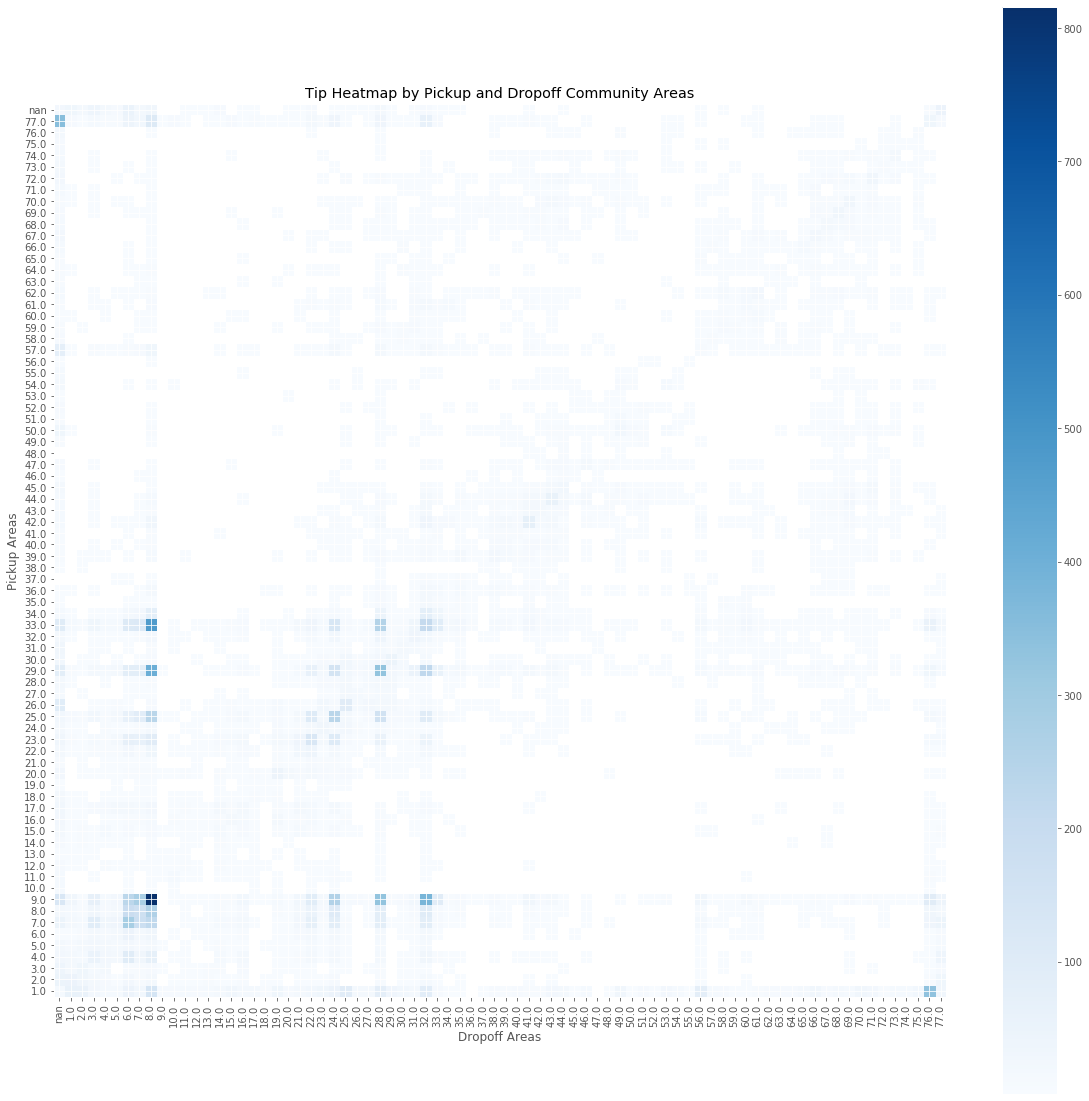

In [24]:
#https://www.pythonpool.com/matplotlib-figsize/
plt.figure(figsize=(20,20))
plt.axes().set_facecolor("#ffffff")
plt.axes().set_ylabel("Pickup Areas")
plt.axes().set_xlabel("Dropoff Areas")
#https://www.pythonpool.com/matplotlib-heatmap/
plt.xticks(ticks=np.arange(len(pickups)),labels=pickups,rotation=90)
plt.yticks(ticks=np.arange(len(dropoffs)),labels=dropoffs)
hm = plt.imshow(hm_data,cmap='Blues',interpolation="none")
plt.colorbar(hm)
plt.title("Tip Heatmap by Pickup and Dropoff Community Areas")

/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


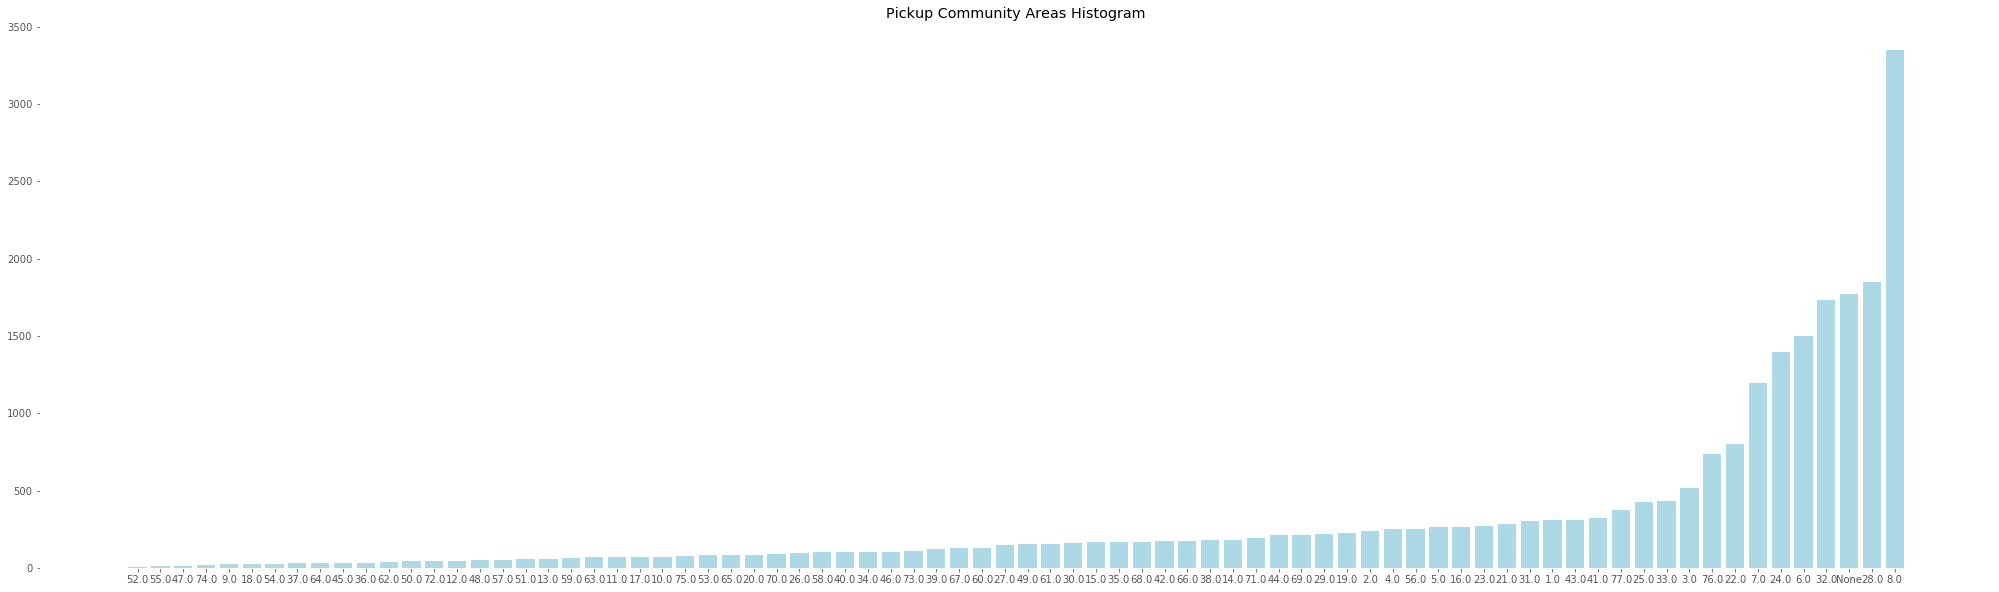

In [25]:
pickups_hist = df2.groupby('Pickup_Community_Area').count().withColumnRenamed("count","area_count").sort("area_count")
#https://stackoverflow.com/questions/38610559/convert-spark-dataframe-column-to-python-list
areas = [str(x.Pickup_Community_Area) for x in pickups_hist.collect()]
area_count = [x.area_count for x in pickups_hist.collect()]
plt.figure(figsize=(35,10))
plt.bar(areas,area_count, color='lightblue')
plt.title('Pickup Community Areas Histogram')
plt.axes().set_facecolor("#ffffff")

/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


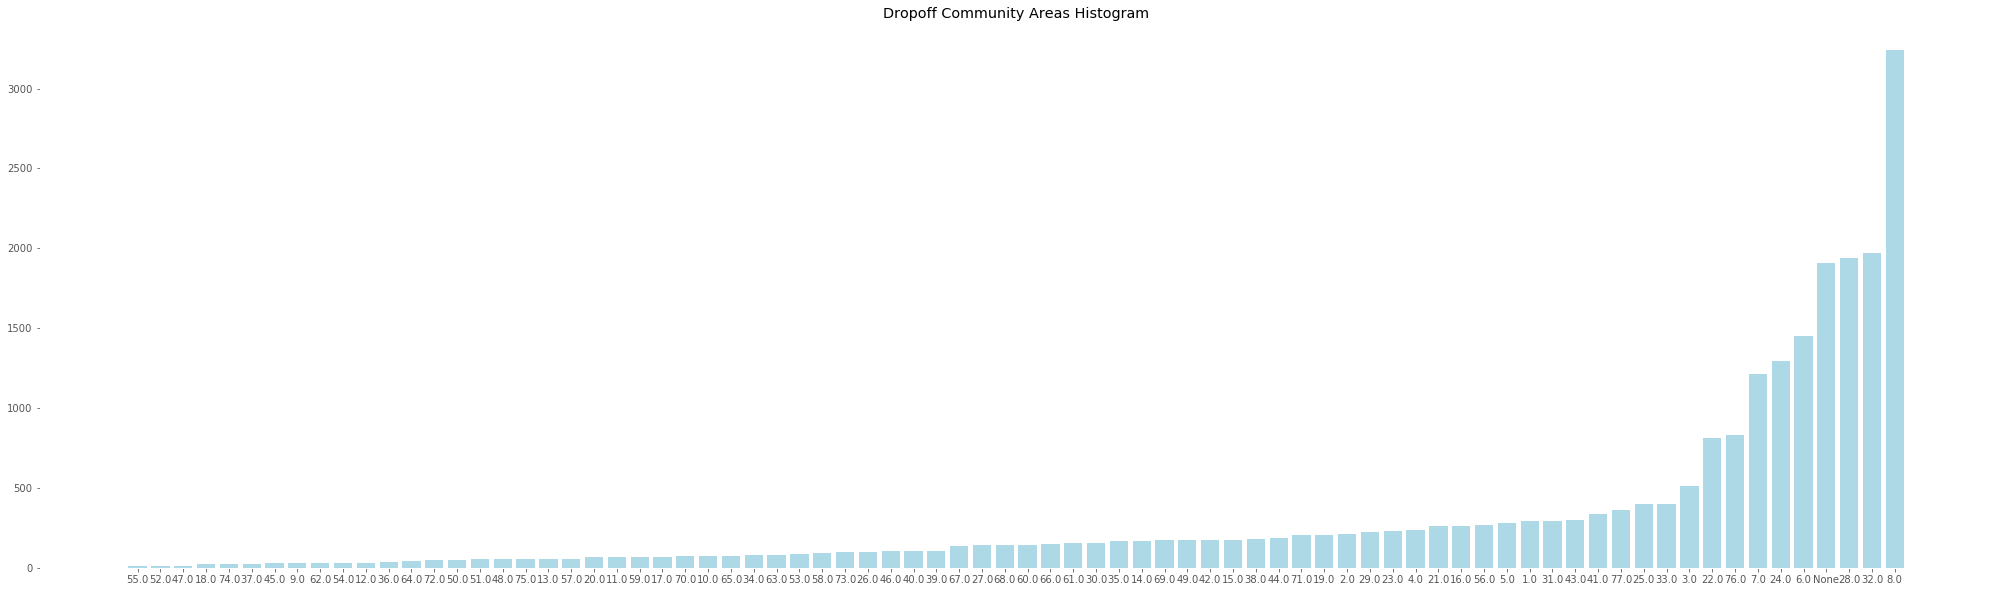

In [26]:
pickups_hist = df2.groupby('Dropoff_Community_Area').count().withColumnRenamed("count","area_count").sort("area_count")
areas = [str(x.Dropoff_Community_Area) for x in pickups_hist.collect()]
area_count = [x.area_count for x in pickups_hist.collect()]
plt.figure(figsize=(35,10))
plt.bar(areas,area_count, color='lightblue')
plt.title('Dropoff Community Areas Histogram')
plt.axes().set_facecolor("#ffffff")

### Looking a little closer at the data

only showed top 10 as we have pretty large fall off.  now to replace nulls with actual values.  Will assume to used 99 for outside the city

In [27]:
#now lets sort the list, added desc to order the list from largest to smallest

df2.groupby('Pickup_Community_Area').count().orderBy('count', ascending=False).show(10)

+---------------------+-----+
|Pickup_Community_Area|count|
+---------------------+-----+
|                  8.0| 3350|
|                 28.0| 1852|
|                 null| 1773|
|                 32.0| 1732|
|                  6.0| 1498|
|                 24.0| 1397|
|                  7.0| 1199|
|                 22.0|  798|
|                 76.0|  735|
|                  3.0|  515|
+---------------------+-----+
only showing top 10 rows



just for reference

Top Pickup Areas

* 8 is the area of magnificiant mile, riverwalk, Gold Coast Neigherborhood, and Navy Pier (tourist trap)
* 28 is the near west side, I think lots of condos and new resturants
* null it outside the city
* 32 is "The Loop" downtown busisness district, train EL hub
* 6 is Lakeview, Near north neigherbood perdominatly white and Cubs Stadium
* 24 West Town don't know as well, likely where Bulls play.  Need to verify
* 7 Lincoln Park.  Like Lakeview but more expensive
* 22 Logan Square.  Edge of transitioning neigherbood.  More afforable for new (white) owners
* 76 O'Hare Airport
* 3 Uptown, north of lakeview, like Logan Square less expensive, 

In [28]:
# do the same for the dropoffs
df2.groupby('Dropoff_Community_Area').count().orderBy('count', ascending=False).show(10)

+----------------------+-----+
|Dropoff_Community_Area|count|
+----------------------+-----+
|                   8.0| 3241|
|                  32.0| 1972|
|                  28.0| 1942|
|                  null| 1911|
|                   6.0| 1449|
|                  24.0| 1296|
|                   7.0| 1213|
|                  76.0|  829|
|                  22.0|  814|
|                   3.0|  514|
+----------------------+-----+
only showing top 10 rows



For reference:

Dropoff Areas

* 8 is the area of magnificiant mile, riverwalk, Gold Coast Neigherborhood, and Navy Pier (tourist trap)
* 32 is "The Loop" downtown busisness district, train EL hub
* 28 is the near west side, I think lots of condos and new resturants
* null it outside the city
* 6 is Lakeview, Near north neigherbood perdominatly white and Cubs Stadium
* 24 West Town don't know as well, likely where Bulls play.  Need to verify
* 7 Lincoln Park.  Like Lakeview but more expensive
* 76 O'Hare Airport
* 22 Logan Square.  Edge of transitioning neigherbood.  More afforable for new (white) owners
* 3 Uptown, north of lakeview, like Logan Square less expensive, 

The lists are almost identical, just a few order changes.

How much of the traffic comes from these heavy use neigherborhoods?  

In [29]:
df3 = df2.na.fill(value=99,subset=['Pickup_Community_Area', 'Dropoff_Community_Area'])

In [30]:
df3.groupby('Dropoff_Community_Area').count().orderBy('count', ascending=False).show(10)

+----------------------+-----+
|Dropoff_Community_Area|count|
+----------------------+-----+
|                   8.0| 3241|
|                  32.0| 1972|
|                  28.0| 1942|
|                  99.0| 1911|
|                   6.0| 1449|
|                  24.0| 1296|
|                   7.0| 1213|
|                  76.0|  829|
|                  22.0|  814|
|                   3.0|  514|
+----------------------+-----+
only showing top 10 rows



In [31]:
df3.groupby('Pickup_Community_Area').count().orderBy('count', ascending=False).show(10)

+---------------------+-----+
|Pickup_Community_Area|count|
+---------------------+-----+
|                  8.0| 3350|
|                 28.0| 1852|
|                 99.0| 1773|
|                 32.0| 1732|
|                  6.0| 1498|
|                 24.0| 1397|
|                  7.0| 1199|
|                 22.0|  798|
|                 76.0|  735|
|                  3.0|  515|
+---------------------+-----+
only showing top 10 rows



Looks like it works to change the nulls to a 99 for the community area.

Next lets add a colum with the tip or no tip as a binary

now that we have that, can we do group by tips and our pickup/dropoff areas?

In [32]:
binarizedTip.groupby('Dropoff_Community_Area', 'binarized_tip').count().orderBy('Dropoff_Community_Area', ascending=False).show(50)

+----------------------+-------------+-----+
|Dropoff_Community_Area|binarized_tip|count|
+----------------------+-------------+-----+
|                  77.0|          1.0|   86|
|                  77.0|          0.0|  277|
|                  76.0|          1.0|  258|
|                  76.0|          0.0|  571|
|                  75.0|          1.0|    3|
|                  75.0|          0.0|   53|
|                  74.0|          0.0|   14|
|                  74.0|          1.0|    9|
|                  73.0|          0.0|   93|
|                  73.0|          1.0|    5|
|                  72.0|          1.0|    7|
|                  72.0|          0.0|   41|
|                  71.0|          1.0|    9|
|                  71.0|          0.0|  195|
|                  70.0|          0.0|   67|
|                  70.0|          1.0|    5|
|                  69.0|          0.0|  159|
|                  69.0|          1.0|   12|
|                  68.0|          1.0|    8|
|         